### Identify cause of convection in historical experiment when compared with present day

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import weddell_convect, ross_convect

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'

## Vertical heat diffusivities

In [3]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}

Look at what happens just at the shelfbreak:

In [4]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None), file_type='grid_T'):
    if file_type=='grid_W': 
        name_remapping1 = {'nav_lev':'depthw'}
        mask = 'tmask'
    elif file_type=='grid_T':
        name_remapping1 = {'nav_lev':'deptht'}
        mask = 'tmask'
    elif file_type=='grid_U': mask = 'umask'; name_remapping1={'nav_lev':'depthu'};
    elif file_type=='grid_V': mask = 'vmask'; name_remapping1={'nav_lev':'depthv'};

    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name='area'
    if file_type=='grid_T': area_name = 'area_grid_T'; name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
    else: name_remapping2={} 
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var

In [5]:
def plot_hovmoeller(region_var, ylim=(1600, 0), vmin=0, vmax=1e-2, cmap=cmocean.cm.haline, grid_type='T'):

    if grid_type=='T': depth='deptht'
    elif grid_type=='W': depth='depthw'
    elif grid_type=='U': depth='depthu'
    elif grid_type=='V': depth='depthv'

    fig, ax = plt.subplots(1,1, figsize=(18,5))
    xx, yy = np.meshgrid(region_var.time_counter, region_var[depth])
    
    cb = ax.pcolormesh(xx.transpose(), yy.transpose(), region_var, vmin=vmin, vmax=vmax, cmap=cmap)
    
    fig.colorbar(cb, ax=ax)
    ax.set_ylim(ylim[0], ylim[1])

    return fig, ax

In [6]:
run_dir = f'{base_dir}output/ERA5_test7a_1/files/'
time_slice=(0,240)

# weddell_shelf_vdiff = extract_region_var(run_dir, 'difvho', weddell_west_shelf, file_slice=time_slice, file_type='grid_W')
# weddell_shelf_Uvel  = extract_region_var(run_dir, 'uo'    , weddell_west_shelf, file_slice=time_slice, file_type='grid_U')
# weddell_shelf_Vvel  = extract_region_var(run_dir, 'vo'    , weddell_west_shelf, file_slice=time_slice, file_type='grid_V')
weddell_shelf_T     = extract_region_var(run_dir, 'thetao', weddell_west_shelf, file_slice=time_slice, file_type='grid_T')
weddell_shelf_S     = extract_region_var(run_dir, 'so'    , weddell_west_shelf, file_slice=time_slice, file_type='grid_T')

# weddell_basin_vdiff = extract_region_var(run_dir, 'difvho', weddell_basin     , file_slice=time_slice, file_type='grid_W')
# weddell_basin_Uvel  = extract_region_var(run_dir, 'uo'    , weddell_basin     , file_slice=time_slice, file_type='grid_U')
# weddell_basin_Vvel  = extract_region_var(run_dir, 'vo'    , weddell_basin     , file_slice=time_slice, file_type='grid_V')
weddell_basin_T     = extract_region_var(run_dir, 'thetao', weddell_basin     , file_slice=time_slice, file_type='grid_T')
weddell_basin_S     = extract_region_var(run_dir, 'so'    , weddell_basin     , file_slice=time_slice, file_type='grid_T')

In [ ]:
weddell_basin_shear = ((weddell_basin_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
                       (weddell_basin_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))
weddell_shelf_shear = ((weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
                       (weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))

weddell_basin_rho = gsw.density.rho(weddell_basin_S, weddell_basin_T, weddell_basin_T.deptht) # nemo_mesh_ds.deptht
weddell_basin_N2  = -9.81*1e-3*weddell_basin_rho.diff(dim='deptht')
weddell_shelf_rho = gsw.density.rho(weddell_shelf_S, weddell_shelf_T, weddell_shelf_T.deptht) # nemo_mesh_ds.deptht
weddell_shelf_N2  = -9.81*1e-3*weddell_shelf_rho.diff(dim='deptht')

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


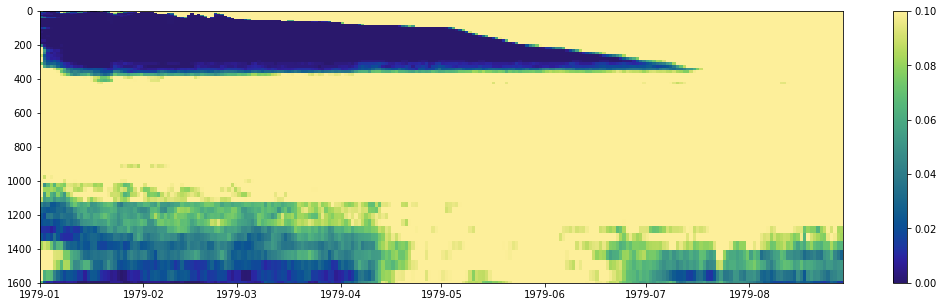

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_vdiff, grid_type='W', vmin=0, vmax=1e-1)

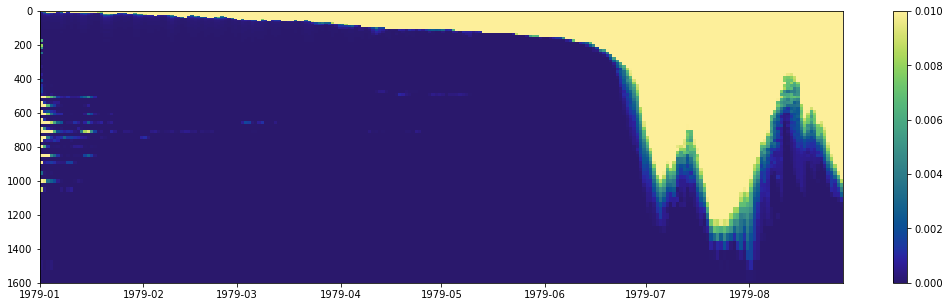

In [9]:
fig1, ax1 = plot_hovmoeller(weddell_basin_vdiff, grid_type='W', vmin=0, vmax=1e-2)

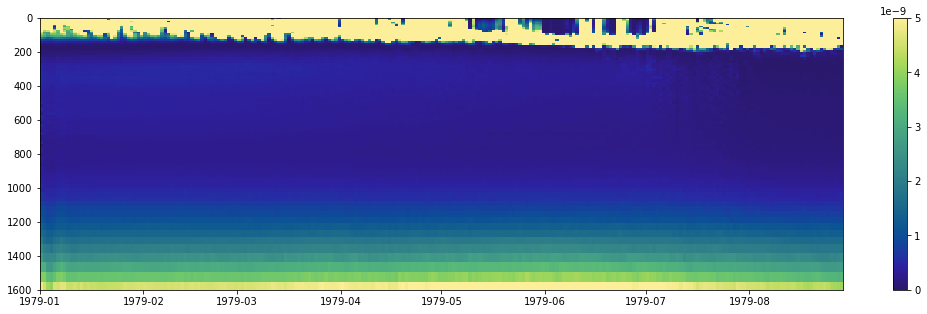

In [10]:
fig1, ax1 = plot_hovmoeller(weddell_basin_shear, grid_type='T', vmin=0, vmax=5e-9)

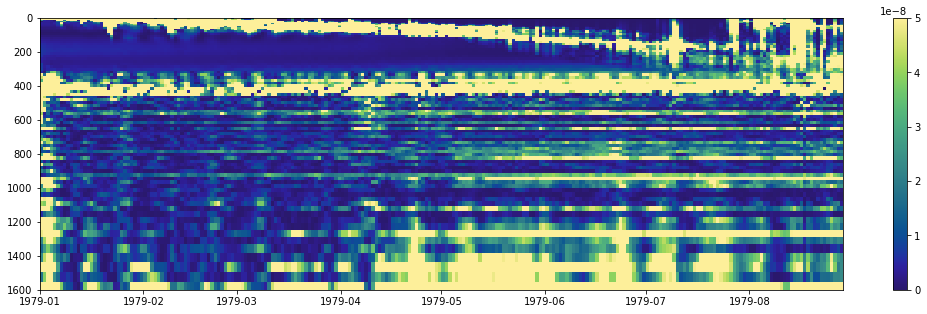

In [11]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_shear, grid_type='T', vmin=0, vmax=5e-8)

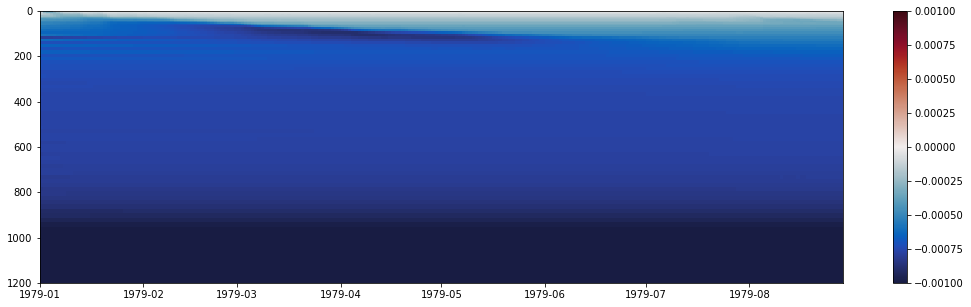

In [12]:
fig1, ax1 = plot_hovmoeller(weddell_basin_N2, grid_type='T', vmin=-1e-3, vmax=1e-3, ylim=(1200,0), cmap=cmocean.cm.balance)

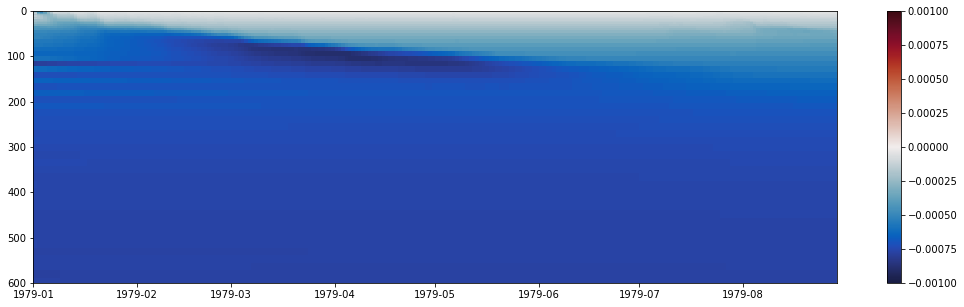

In [13]:
fig1, ax1 = plot_hovmoeller(weddell_basin_N2, grid_type='T', vmin=-1e-3, vmax=1e-3, ylim=(600,0), cmap=cmocean.cm.balance)

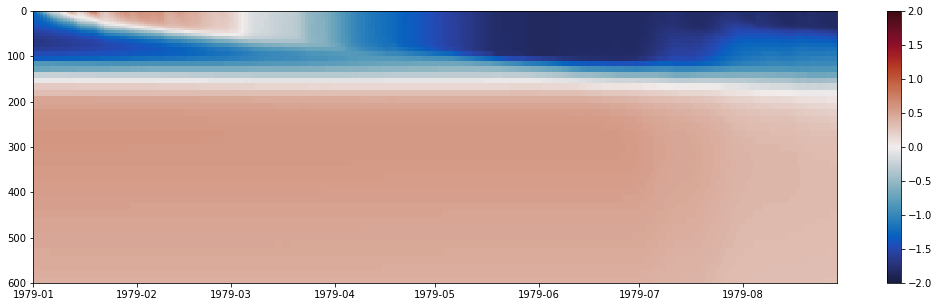

In [14]:
fig1, ax1 = plot_hovmoeller(weddell_basin_T, grid_type='T', vmin=-2, vmax=2, ylim=(600,0), cmap=cmocean.cm.balance)

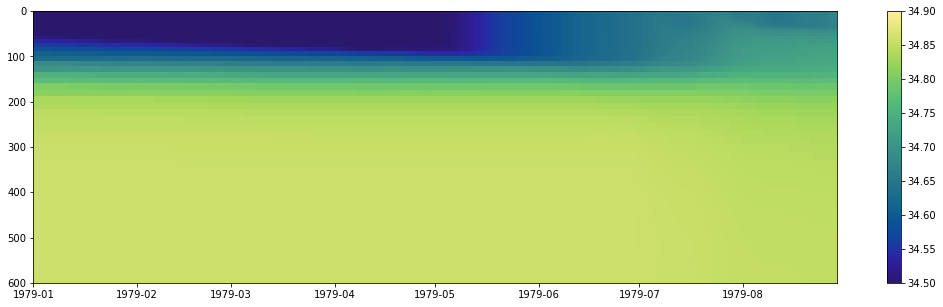

In [15]:
fig1, ax1 = plot_hovmoeller(weddell_basin_S, grid_type='T', vmin=34.5, vmax=34.9, ylim=(600,0))

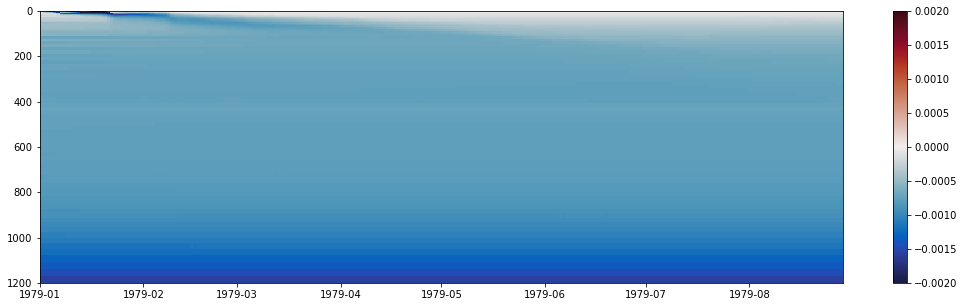

In [16]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_N2, grid_type='T', vmin=-2e-3, vmax=2e-3, ylim=(1200,0), cmap=cmocean.cm.balance)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


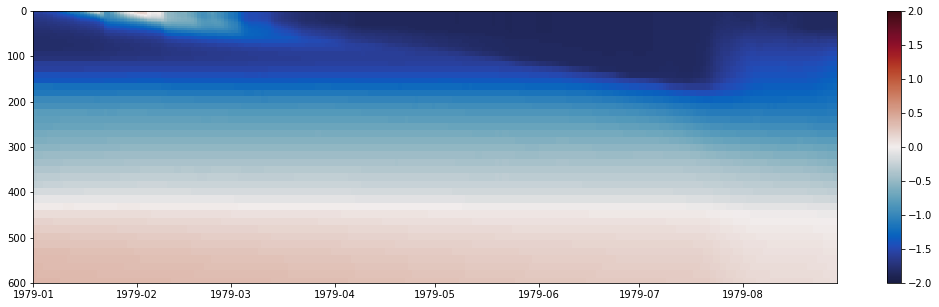

In [7]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_T, grid_type='T', vmin=-2, vmax=2, ylim=(600,0), cmap=cmocean.cm.balance)

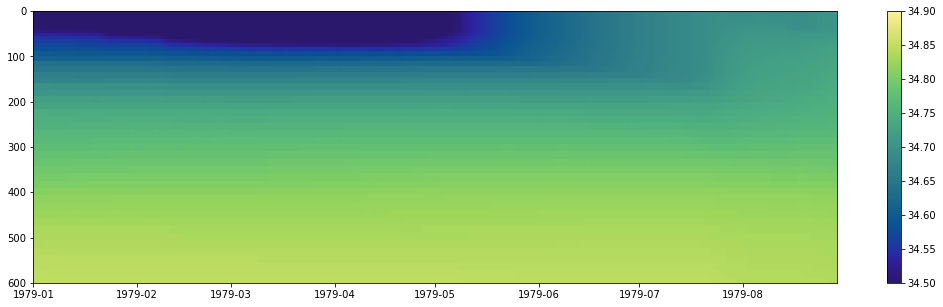

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_S, grid_type='T', vmin=34.5, vmax=34.9, ylim=(600,0))

plot vertical diffusivity map at 600 m for early may to see whether there are particular regions where this feature mainly shows up

In [28]:
ds = xr.open_dataset(f'{base_dir}output/ERA5_test7a_1/files/eANT025.L121_1d_19790101_19791231_grid_T_19790115-19790115.nc')

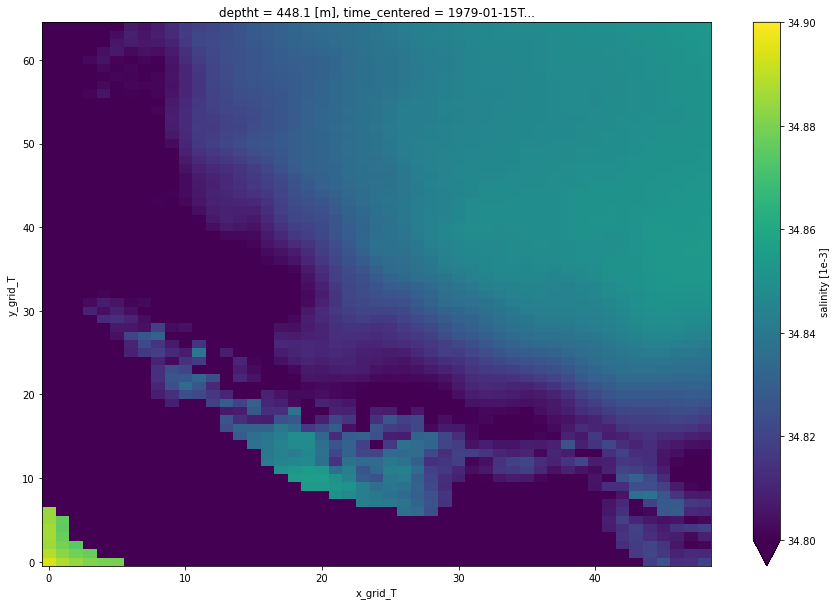

In [34]:
ds.so.isel(time_counter=0).isel(deptht=47, x_grid_T=weddell_west_shelf['x'],
                                y_grid_T=weddell_west_shelf['y']).plot(figsize=(15,10), vmin=34.8, vmax=34.9)

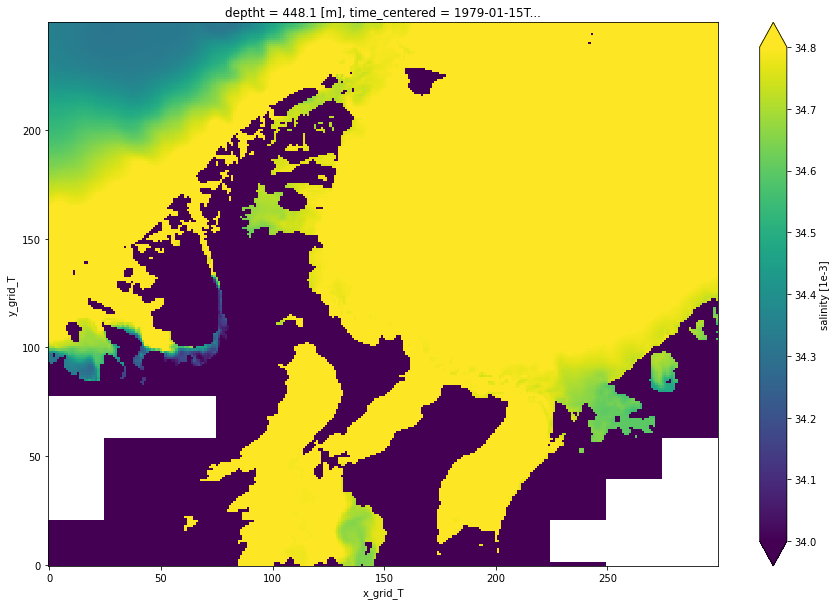

In [29]:
ds.so.isel(time_counter=0).isel(deptht=47, x_grid_T=slice(800,1100), y_grid_T=slice(150,400)).plot(figsize=(15,10), vmin=34.0, vmax=34.8)

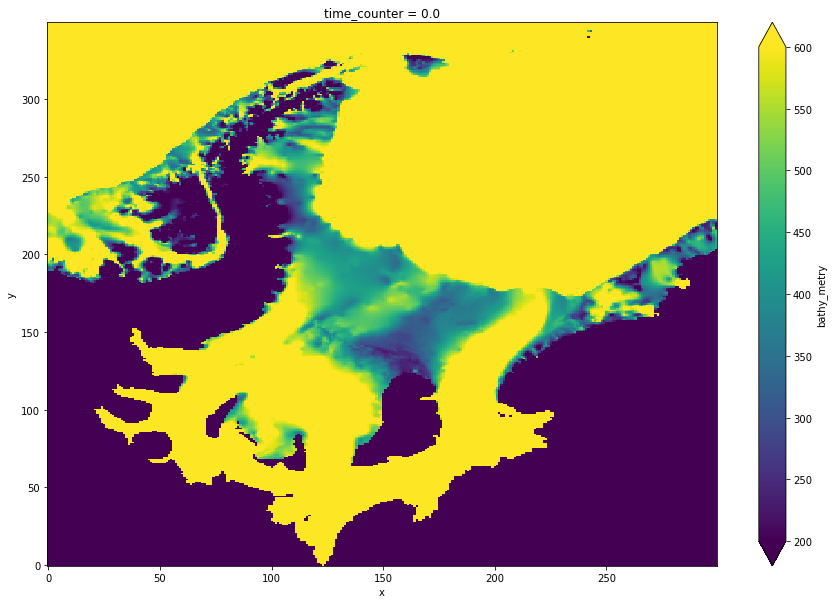

In [14]:
nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0)
nemo_mesh_ds.bathy_metry.isel(x=slice(800,1100), y=slice(50,400)).plot(figsize=(15,10), vmin=200, vmax=600)

In [4]:
# file = glob.glob(f'{run_dir}eANT025*grid_W*')[120]
file = glob.glob(f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/reference-4.2.2/files/eANT025*grid_W*')[0]
mayW = xr.open_dataset(file).squeeze()
# mesh = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0)
# diff = xr.where(mesh.tmask.values==0, np.nan, mayW.difvho)
diff = xr.where(mayW.difvho==0, np.nan, mayW.difvho)

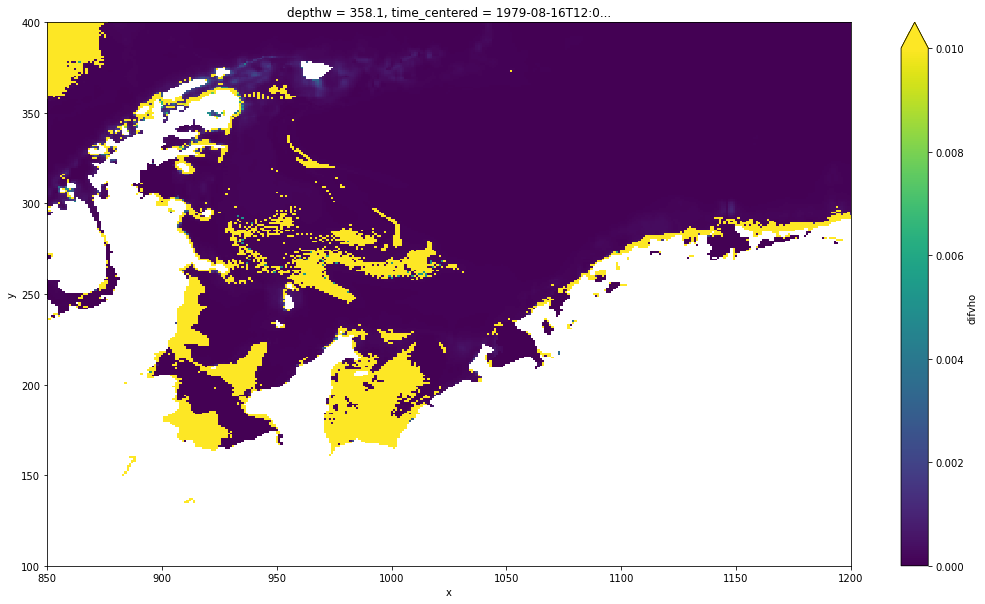

In [5]:
diff.isel(time_counter=7, depthw=42).plot(figsize=(18,10), xlim=(850, 1200), ylim=(100, 400), vmin=0, vmax=1e-2)

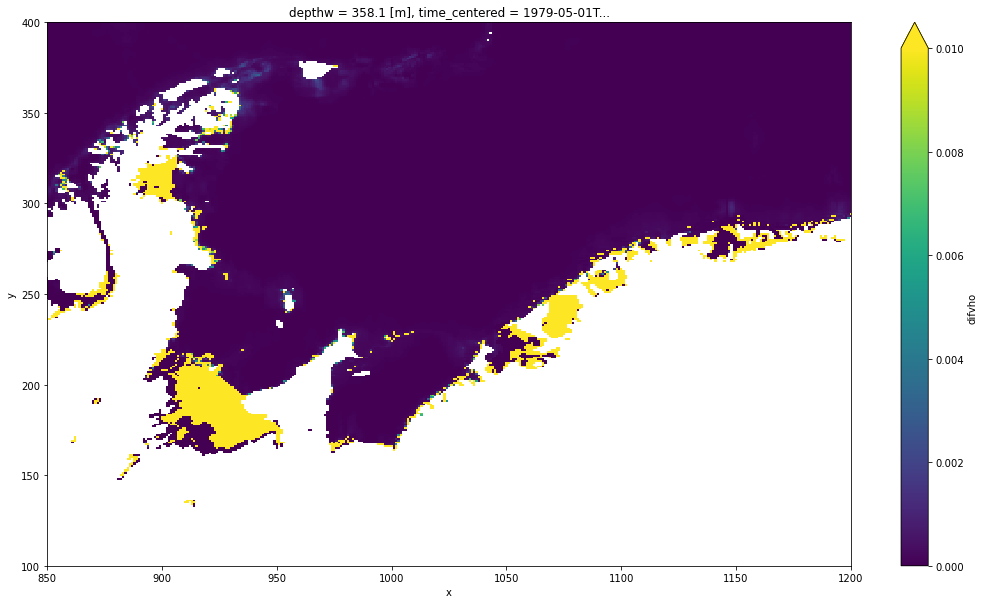

In [55]:
diff.isel(depthw=42).plot(figsize=(18,10), xlim=(850, 1200), ylim=(100, 400), vmin=0, vmax=1e-2)